## Assignment 6 Varun Agrawal MDS202251

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

Question 2

In [2]:
fingerprint1 = cv2.imread("fingerprint1.jpg", 0)
fingerprint2 = cv2.imread("fingerprint2.jpg", 0)
book = cv2.imread("bookpage.jpg", 0)

In [3]:
def all_thresh(image, th_man, th_glo, dt, t1, t2):
    _, manual_thresh = cv2.threshold(image, th_man, 255, cv2.THRESH_BINARY)
    while True:
        average_below_threshold = np.mean(image[image <= th_glo])
        average_above_threshold = np.mean(image[image > th_glo])
        new_threshold = (average_below_threshold + average_above_threshold) / 2
        if abs(new_threshold - th_glo) < dt:
            break
        th_glo = new_threshold
    _, global_thresh = cv2.threshold(image, th_glo, 255, cv2.THRESH_BINARY)
    _, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adapm_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, t1, t2)
    adapg_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, t1, t2)
    return manual_thresh, global_thresh, otsu_thresh, adapm_thresh, adapg_thresh


def display_result(image):
    variable_name = [name for name, obj in globals().items() if obj is image][0]
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'{variable_name}')
    plt.subplot(1, 2, 2)
    plt.plot(hist)
    plt.title('Histogram')
    plt.show()

def display_thresholded_images(image, th_man, th_glo, dt, t1, t2):
    methods = ['Manual', 'Global', 'Otsu', 'Adaptive Mean', 'Adaptive Gaussian' ]
    num_methods = 5
    fig, axes = plt.subplots(1, num_methods, figsize=(25, 15))
    
    for i, (method) in enumerate(zip(methods)):
        threshed_image = all_thresh(image, th_man, th_glo, dt, t1, t2)[i]
        axes[i].imshow(threshed_image, cmap='gray')
        axes[i].set_title(f"Thresholded Image - {method}")
        axes[i].axis('off')

    plt.show()

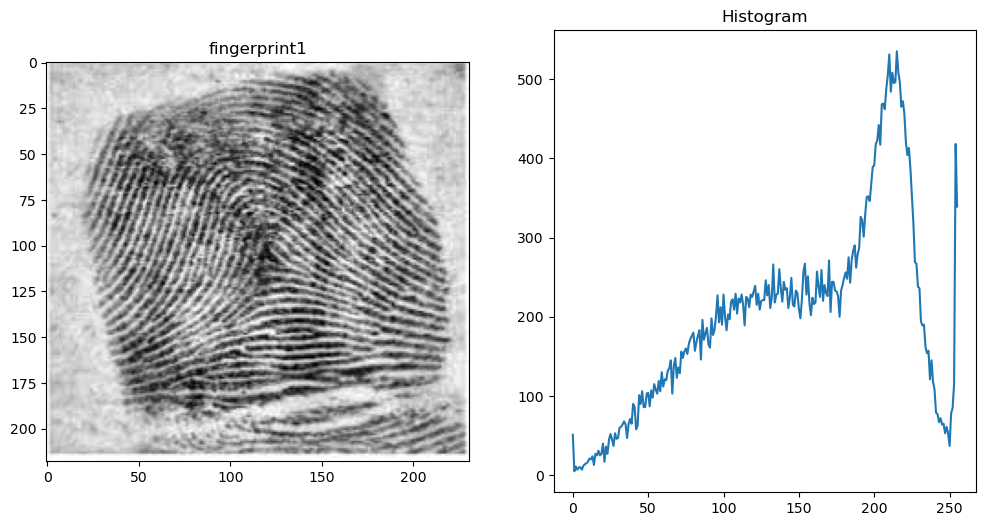

In [4]:
display_result(fingerprint1)

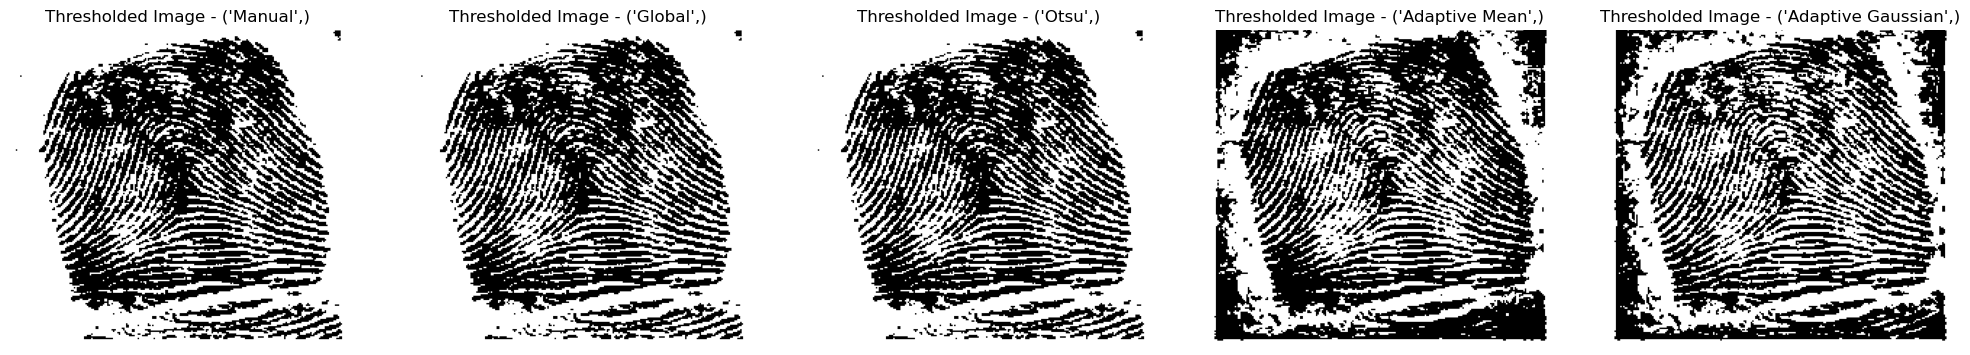

In [5]:
display_thresholded_images(fingerprint1, 150, 128, 0.01, 91, 2)

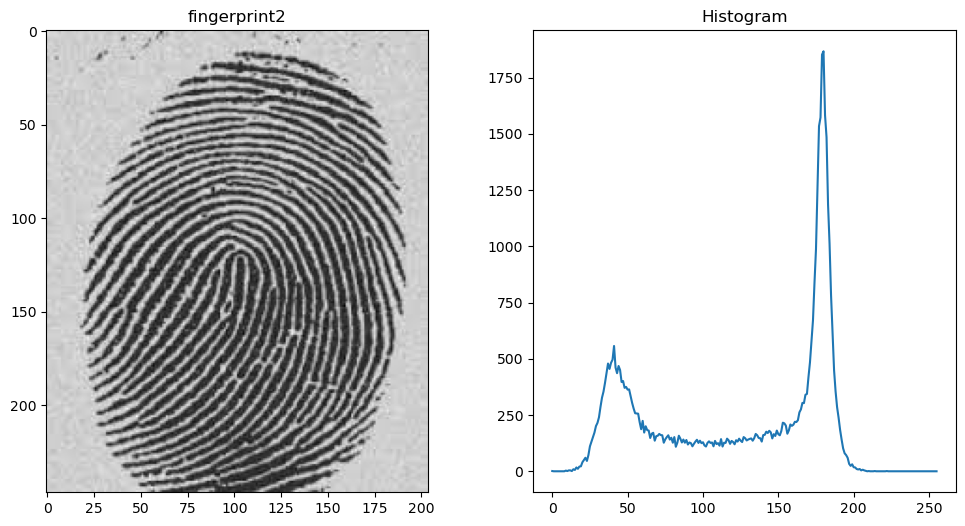

In [6]:
display_result(fingerprint2)

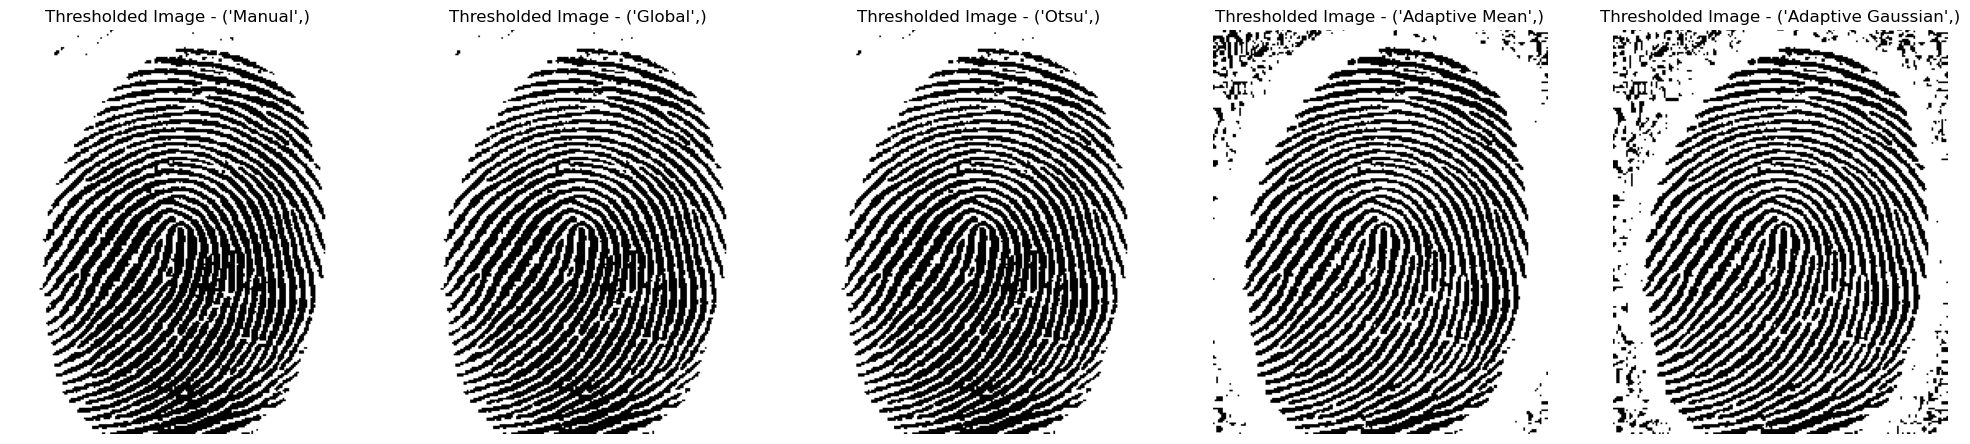

In [7]:
display_thresholded_images(fingerprint2, 120, 128, 0.01, 61, 3)

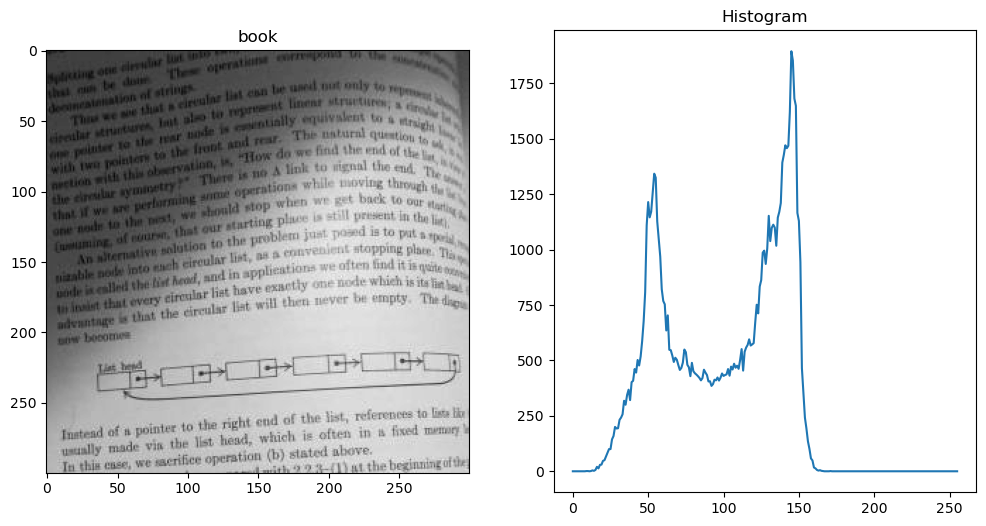

In [8]:
display_result(book)

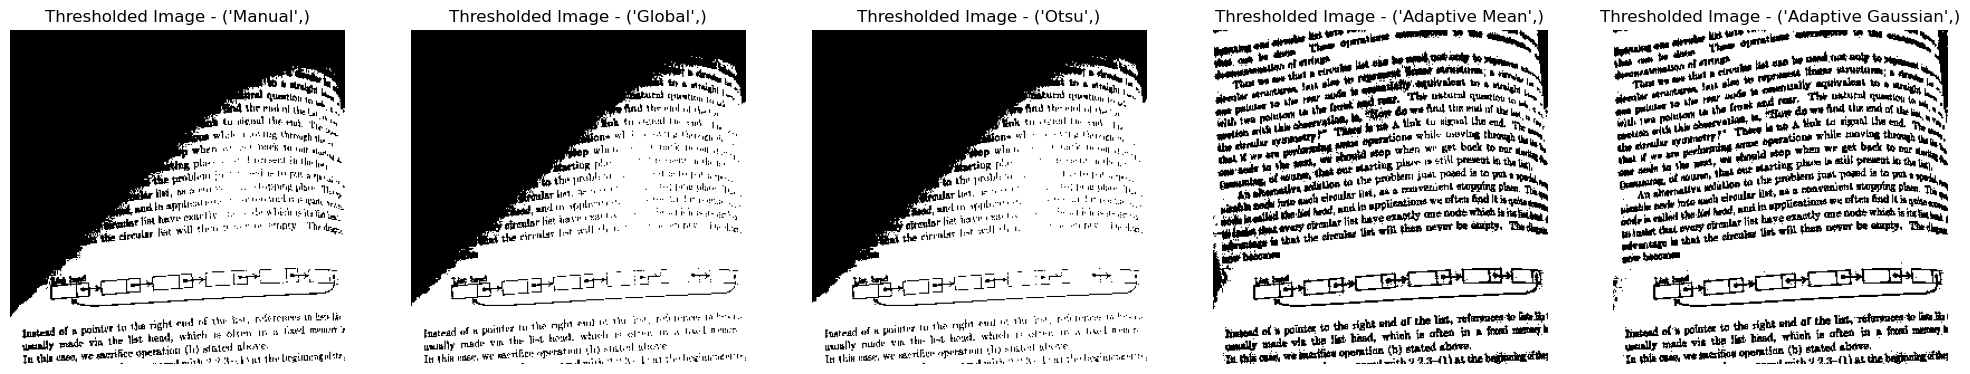

In [9]:
display_thresholded_images(book, 105, 128, 0.01, 73, 4)

The adaptive methods show effectiveness in handling the book content but introduce noticeable artifacts in fingerprint images. Gaussian adaptation demonstrates a slight edge in processing book pages, yet text clarity remains a concern across both methods.

In conclusion, Otsu's method and global and manual thresholding method proves most effective for fingerprint images, while Gaussian adaptation emerges as the preferred choice for enhancing book page visuals.

this might be because: 
Otsu's method performing better on fingerprint images, where local intensity variations are prominent as peaks are visibile and it require precise segmentation, while Gaussian adaptation excels on book pages, where there is different intensity variations across spatial regions.

Question 3

In [10]:
def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def zero_crossing(img, thresh):
    h, w = img.shape
    crossings = np.zeros(img.shape, dtype=np.uint8)
    
    for i in range(1, h-1):
        for j in range(1, w-1):
            neighbors = [img[i-1, j], img[i+1, j], img[i, j-1], img[i, j+1],
                         img[i-1, j-1], img[i-1, j+1], img[i+1, j-1], img[i+1, j+1]]
            signs = np.sign(neighbors)
            zero_cross = any(np.diff(signs))
            if zero_cross and np.max(np.abs(neighbors)) > thresh:
                crossings[i, j] = 255
    
    return crossings

def edge_detection_with_threshold(image):
    # Apply Gaussian smoothing
    smoothed_image = cv2.GaussianBlur(image, (5, 5), 0.3)

    # Sobel kernel
    sobel_x = cv2.Sobel(smoothed_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(smoothed_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edge = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel = (sobel_edge * 255 / sobel_edge.max()).astype(np.uint8)

    # LoG (Laplacian of Gaussian)
    log = cv2.Laplacian(smoothed_image, cv2.CV_64F, ksize=5)
    # Apply thresholding after LoG
    log_zero_crossings = zero_crossing(log, 0.2 * np.max(log))
    
    
    # Canny edge detector
    canny = cv2.Canny(smoothed_image, 50, 210)
    
    
    # Hough transform for edge detection
    edges = cv2.Canny(smoothed_image, 50, 100)
    hough_image = np.zeros_like(smoothed_image)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=25, minLineLength=1, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(hough_image, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
    
    return sobel, log_zero_crossings, canny, hough_image

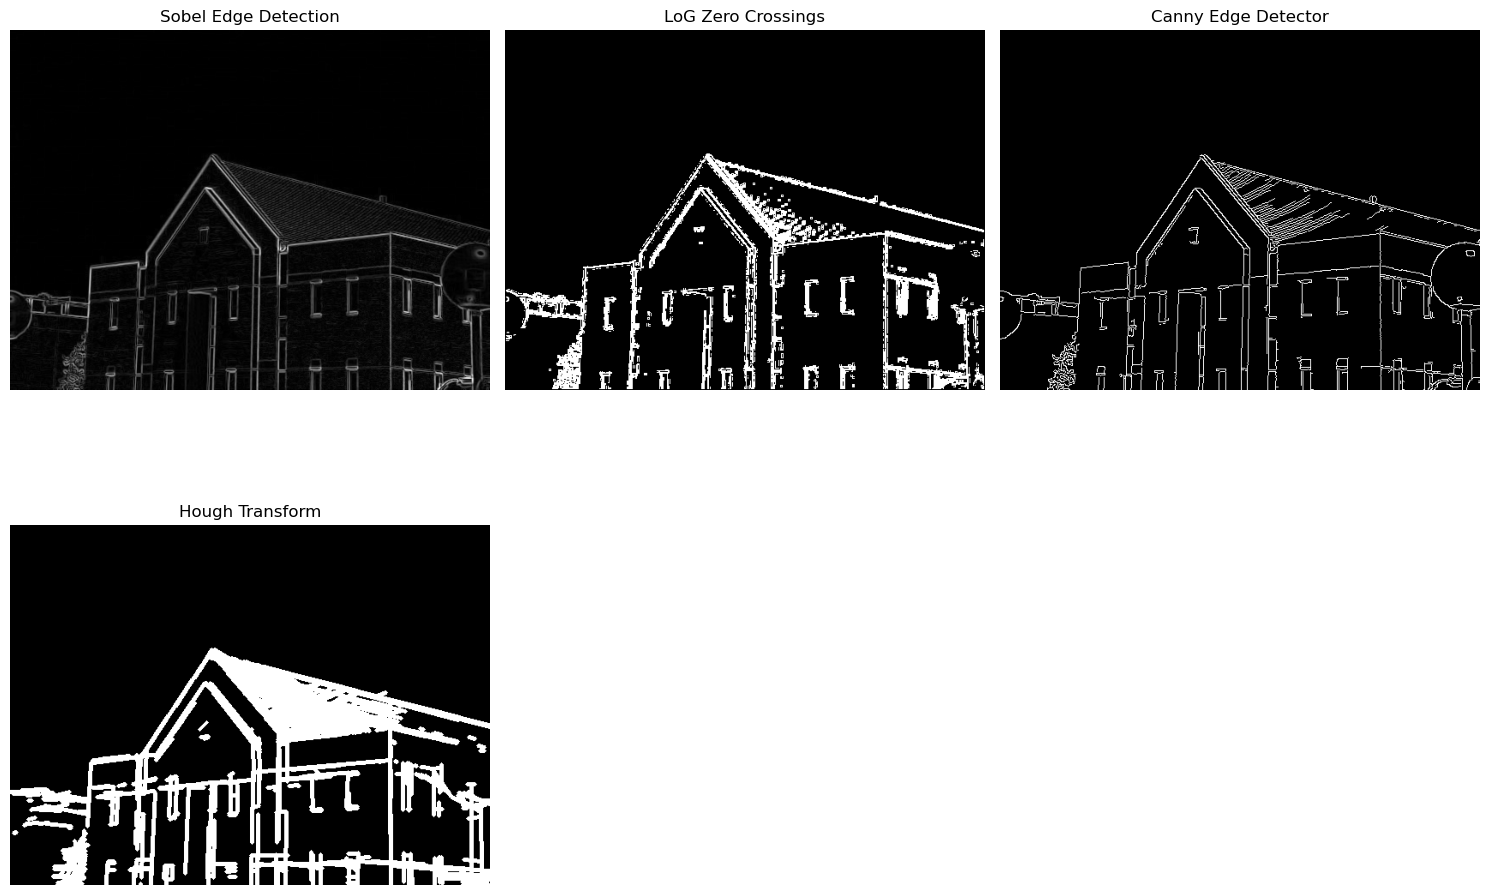

In [11]:
# Load the image
building = cv2.imread('building.jpg', cv2.IMREAD_GRAYSCALE)

# Apply edge detection techniques with thresholding
sobel, log_zero, canny, hough = edge_detection_with_threshold(building)

# Display the results without thrshold
labels = ['Sobel Edge Detection', 'LoG Zero Crossings', 'Canny Edge Detector', 'Hough Transform']
plt.figure(figsize=(15, 15))
for i, result in enumerate([sobel, log_zero, canny, hough]):
    plt.subplot(3, 3, i+1)
    plt.imshow(result, cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


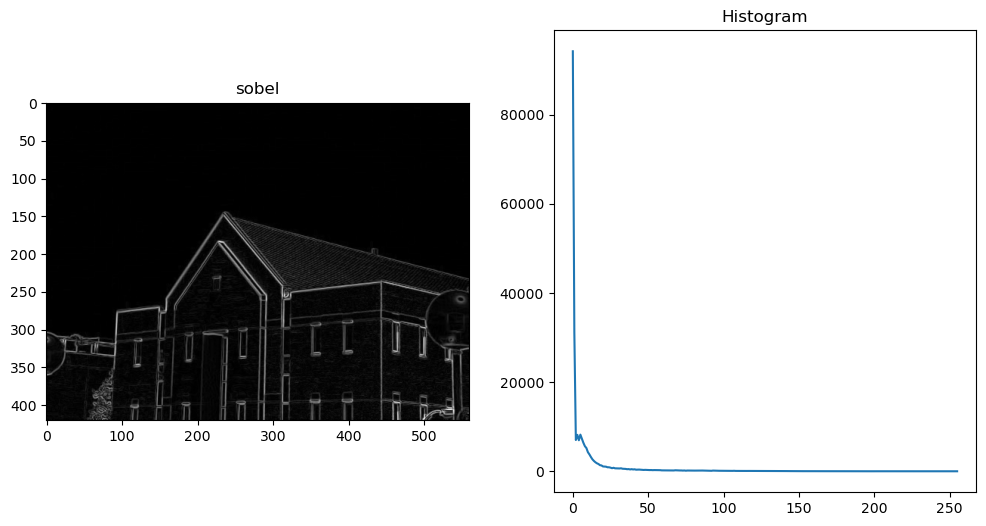

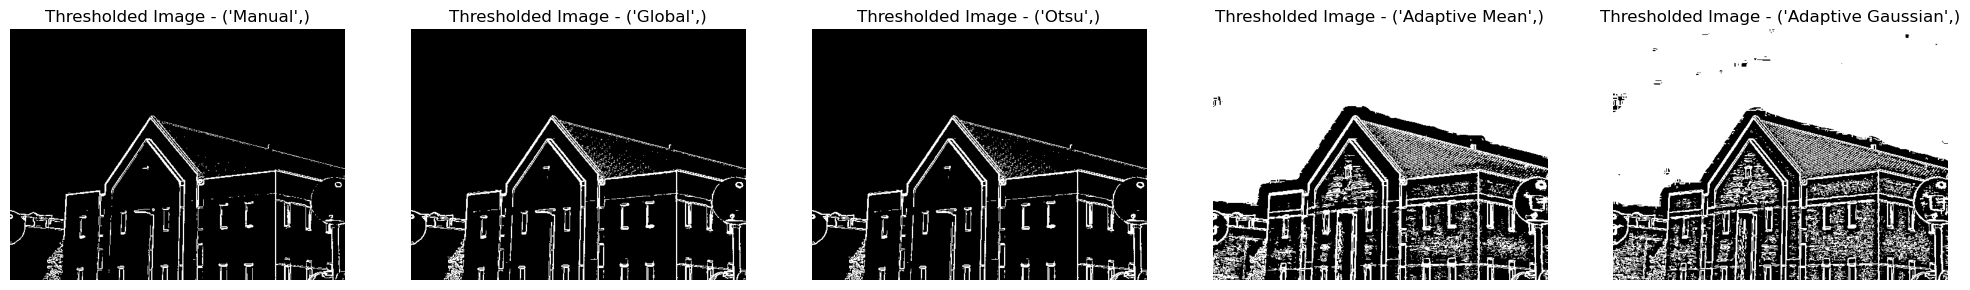

In [12]:
display_result(sobel)
display_thresholded_images(sobel, 55, 25, 0.001, 31, 1)

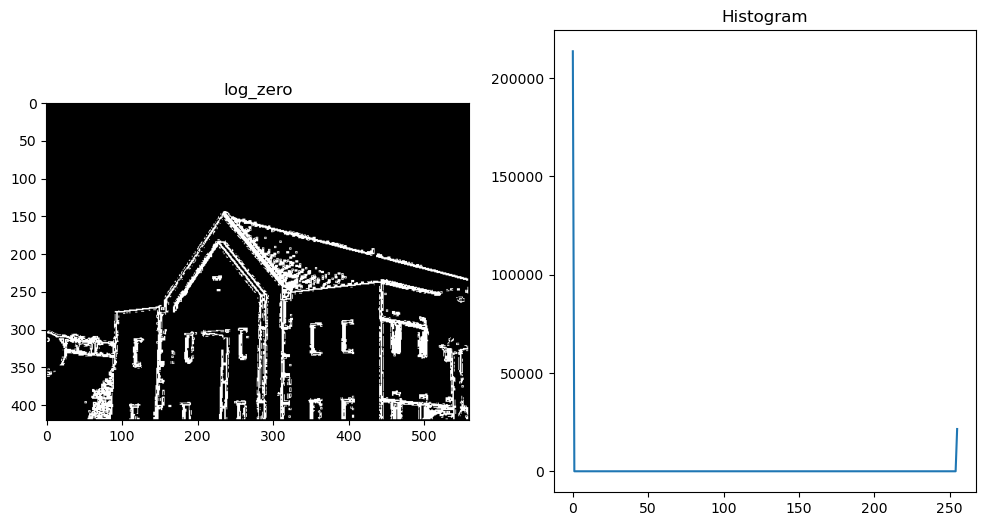

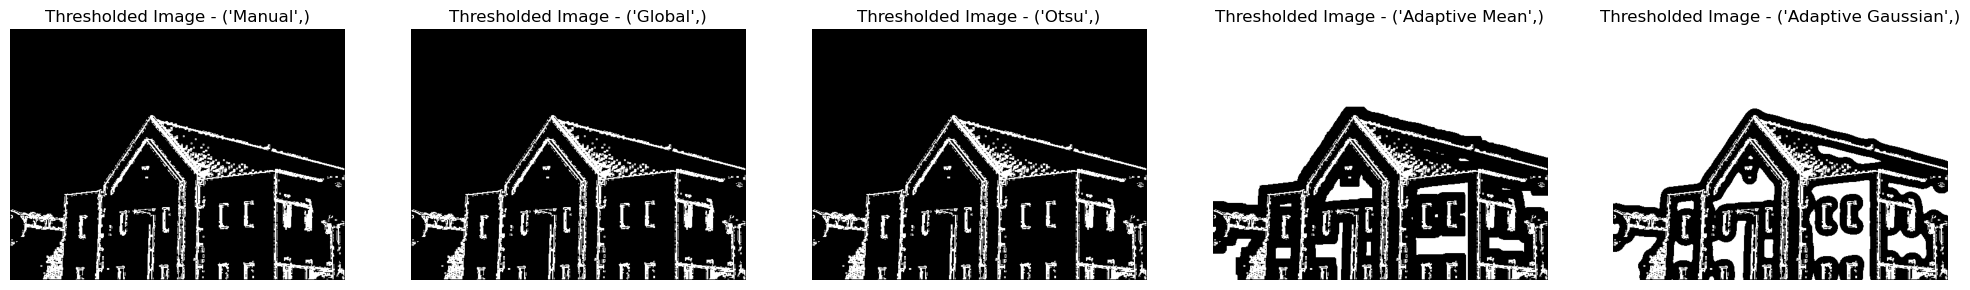

In [13]:
display_result(log_zero)
display_thresholded_images(log_zero, 10, 25, 0.001, 31, 2)

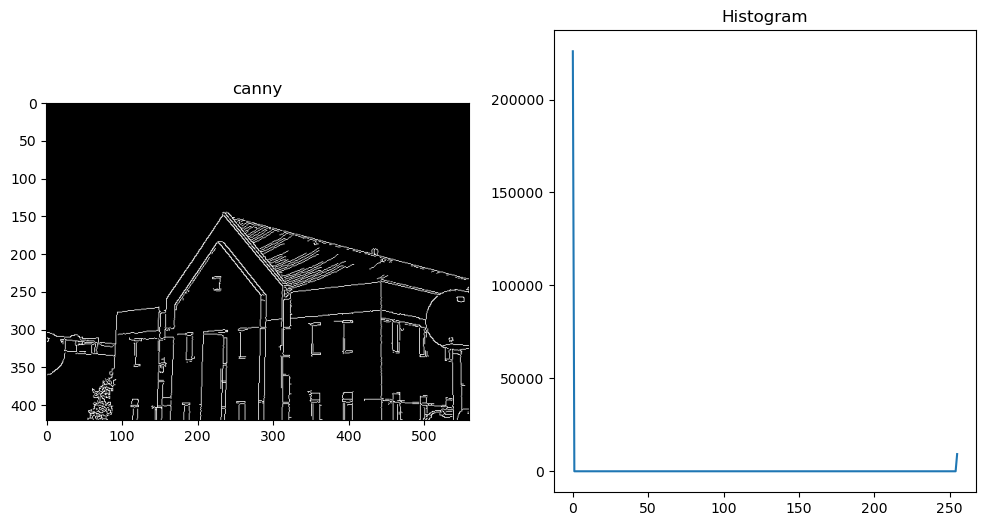

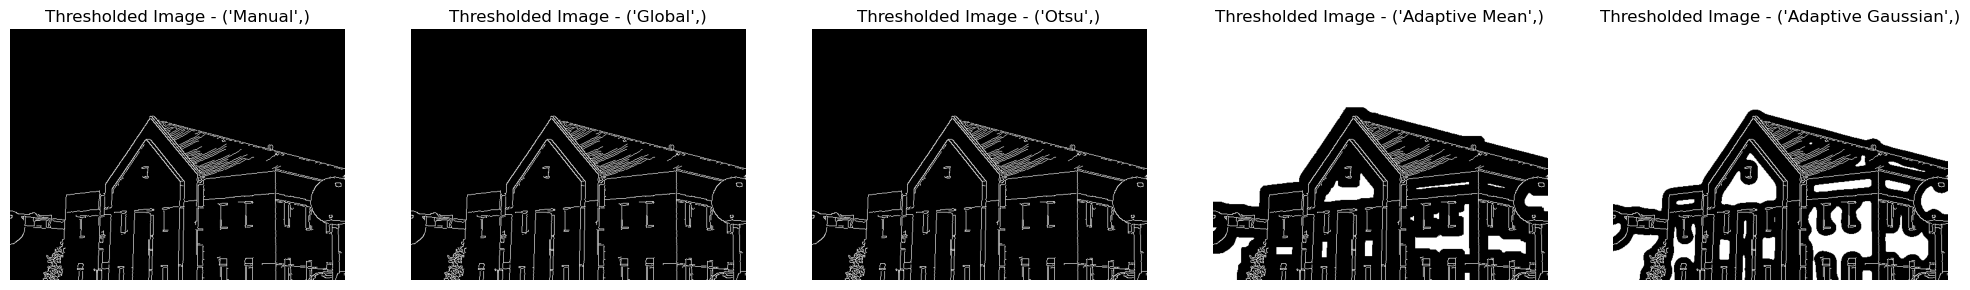

In [14]:
display_result(canny)
display_thresholded_images(canny, 60, 25, 0.01, 31, 2)

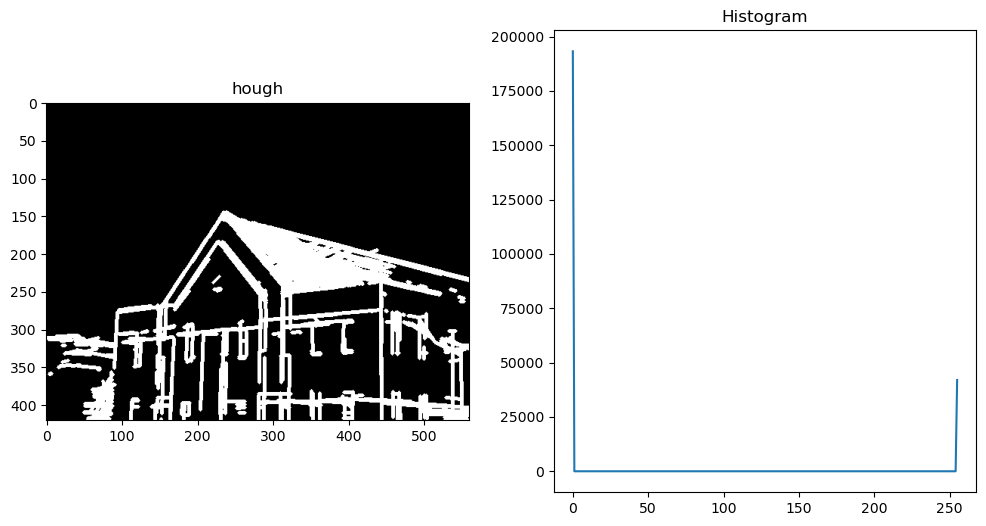

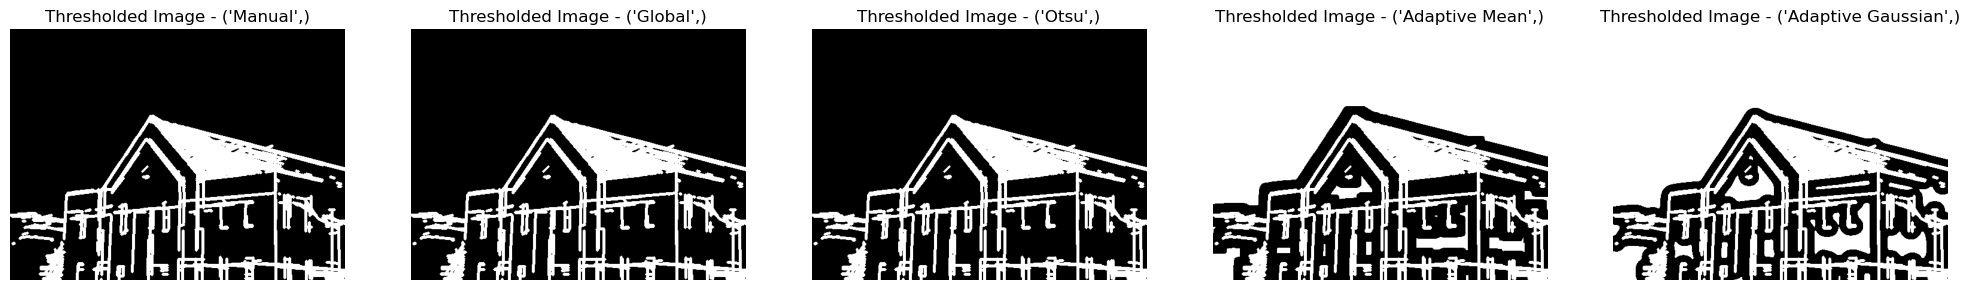

In [15]:
display_result(hough)
display_thresholded_images(hough, 60, 25, 0.01, 31, 2)

In [16]:
def edge_detection_with_threshold(image):
    # Apply Gaussian smoothing
    smoothed_image = cv2.GaussianBlur(image, (7, 7), 2)

    # Sobel kernel
    sobel_x = cv2.Sobel(smoothed_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(smoothed_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edge = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel = (sobel_edge * 255 / sobel_edge.max()).astype(np.uint8)

    # LoG (Laplacian of Gaussian)
    log = cv2.Laplacian(smoothed_image, cv2.CV_64F, ksize=5)
    # Apply thresholding after LoG
    log_zero_crossings = zero_crossing(log, 0.25 * np.max(log))
    
    
    # Canny edge detector
    canny = cv2.Canny(smoothed_image, 50, 80)
    
    
    # Hough transform for edge detection
    edges = cv2.Canny(smoothed_image, 50, 80)
    hough_image = np.zeros_like(smoothed_image)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=25, minLineLength=1, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(hough_image, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
    
    return sobel, log_zero_crossings, canny, hough_image

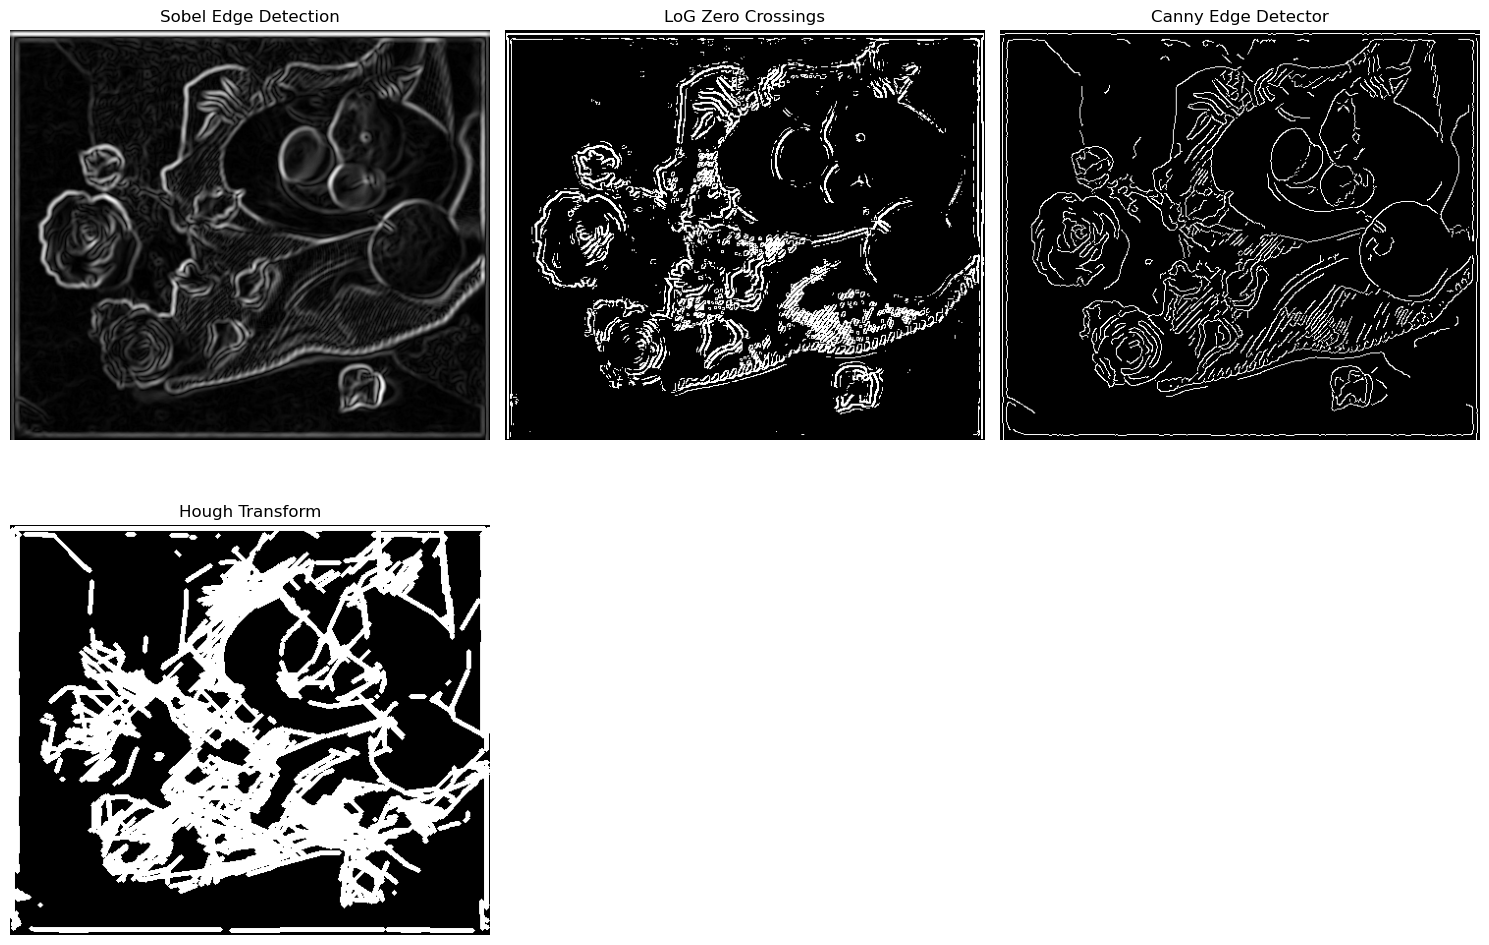

In [17]:
# Load the image
objects = cv2.imread('objects.png', cv2.IMREAD_GRAYSCALE)

# Apply edge detection techniques with thresholding
sobel, log_zero, canny, hough = edge_detection_with_threshold(objects)

# Display the results without thrshold
labels = ['Sobel Edge Detection', 'LoG Zero Crossings', 'Canny Edge Detector', 'Hough Transform']
plt.figure(figsize=(15, 15))
for i, result in enumerate([sobel, log_zero, canny, hough]):
    plt.subplot(3, 3, i+1)
    plt.imshow(result, cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

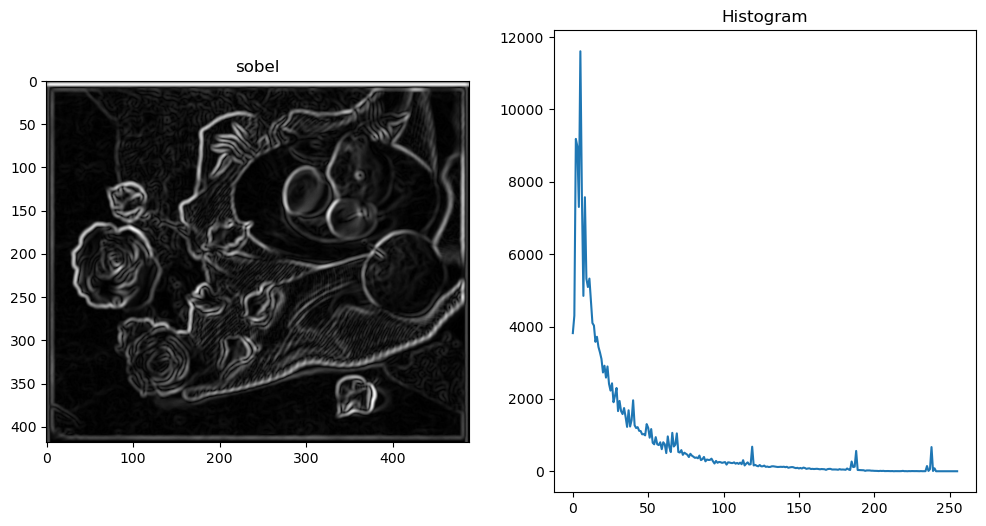

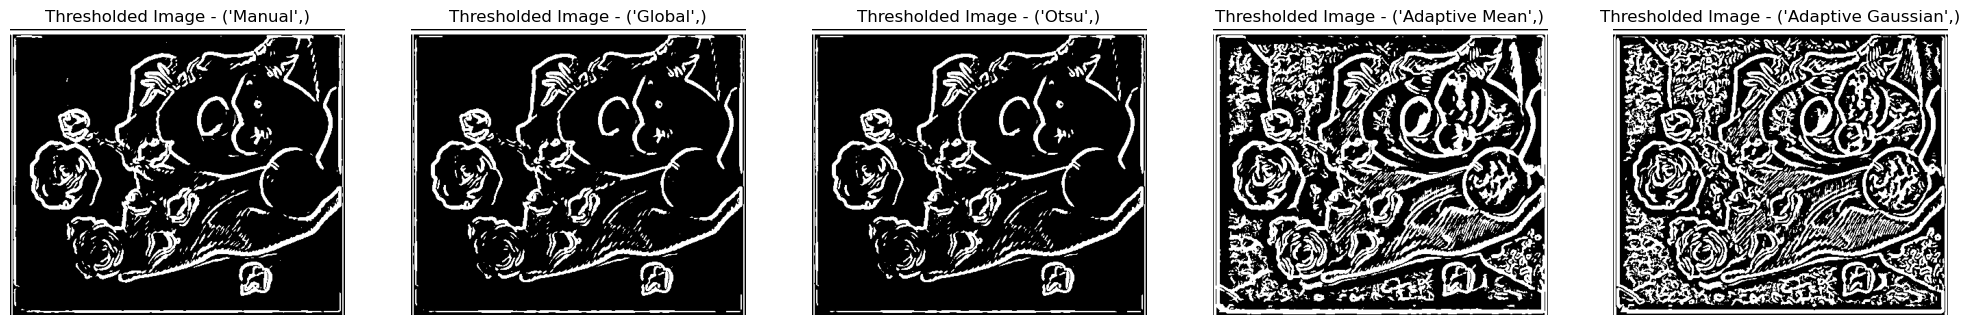

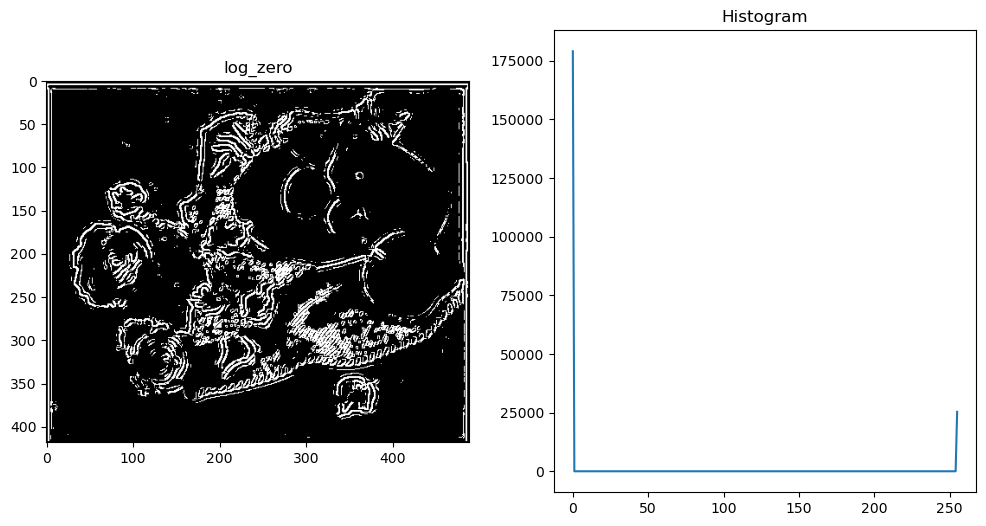

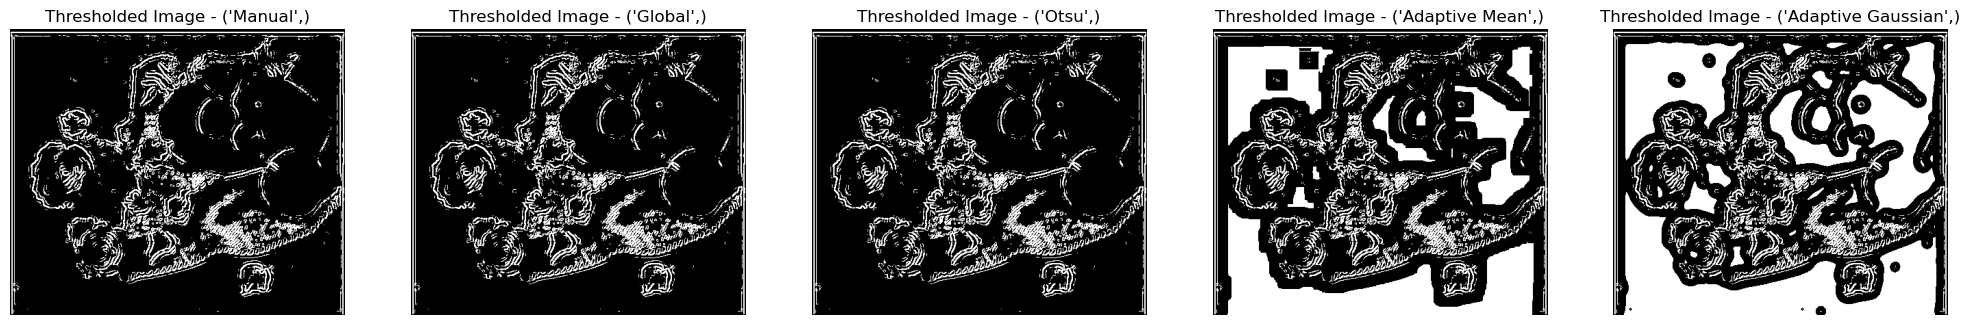

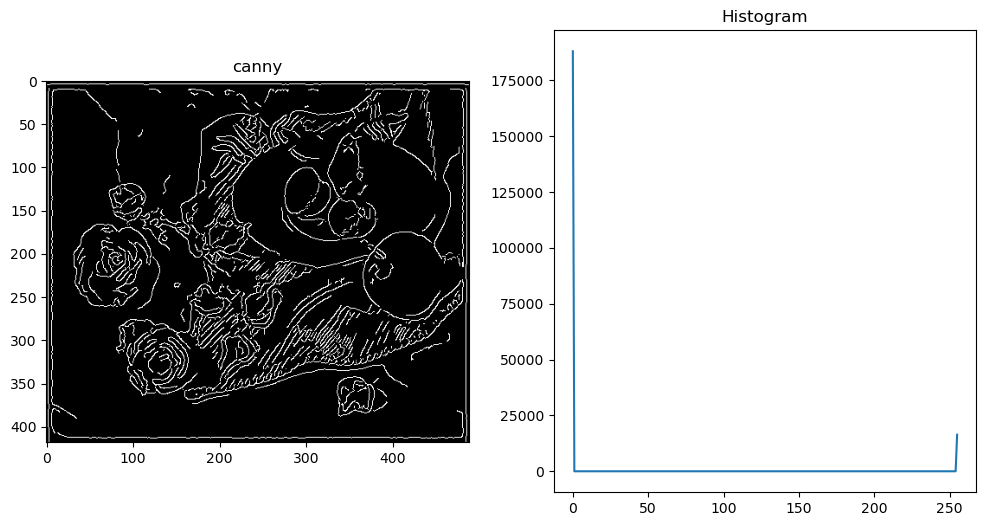

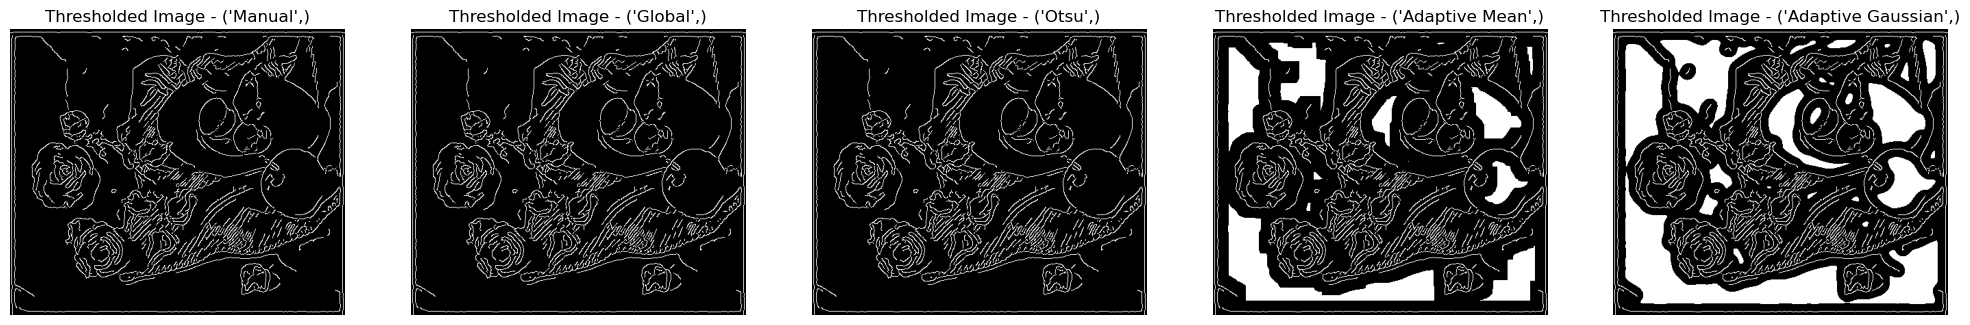

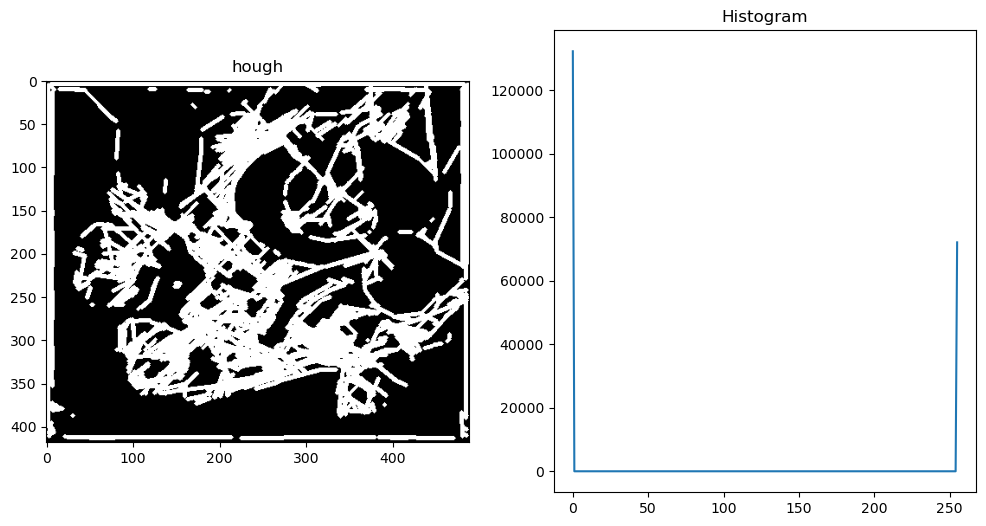

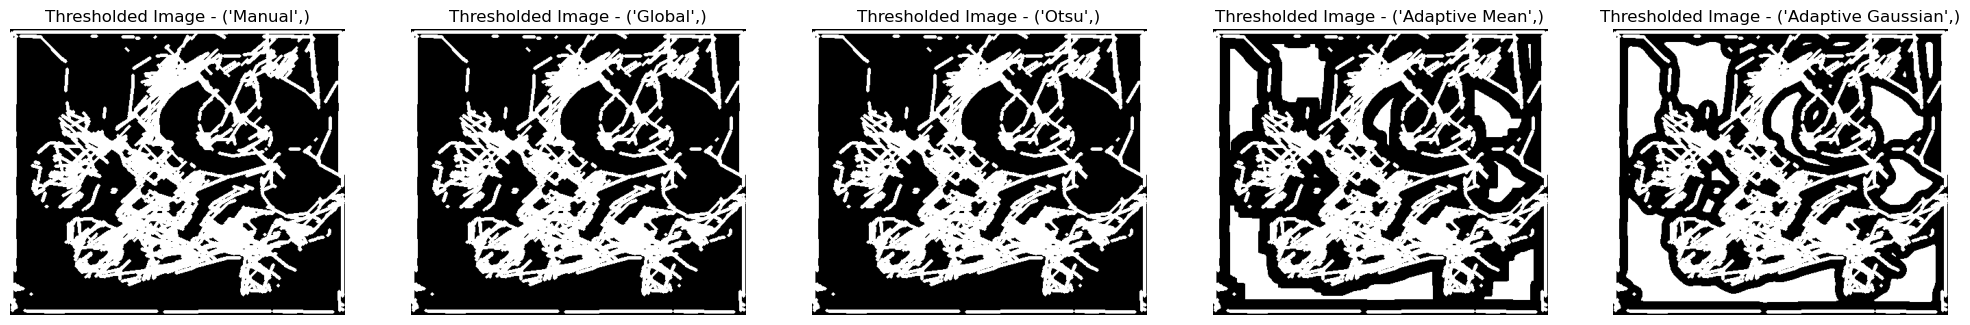

In [19]:
display_result(sobel)
display_thresholded_images(sobel, 55, 25, 0.001, 31, 1)
display_result(log_zero)
display_thresholded_images(log_zero, 10, 25, 0.001, 31, 2)
display_result(canny)
display_thresholded_images(canny, 60, 25, 0.01, 31, 2)
display_result(hough)
display_thresholded_images(hough, 60, 25, 0.01, 31, 2)

- Thick edges are well-detected by Sobel edge detection using Otsu or global thresholding, but it struggles with finer details, a task where adaptive thresholding methods show some effectiveness.
- LoG edge detection surpasses Sobel, providing better delineation of building edges and roof tiles, even outperforming Sobel with Otsu or global thresholding.
- Canny edge detection stands out for its ability to precisely map image boundaries with minimal noise, making it the preferred choice for maintaining clean and continuous edge detection.
- Canny edge detection is particularly effective for buildings, while Sobel edge detection with both global and Otsu thresholding techniques proves more efficient for images featuring curves, such as objects.

All the above is because:

- **Sobel Edge Detection**: Effective for detecting prominent edges, simple to implement.
  
- **LoG (Laplacian of Gaussian) Edge Detection**: Capable of capturing both coarse and fine details, suitable for images with varying scales of edges.

- **Canny Edge Detection**: Precisely maps image boundaries with minimal noise, suitable for maintaining clean and continuous edge detection.

- **Otsu's Method and Global Thresholding**: Simple and straightforward, suitable for images with uniform background.

- **Adaptive Thresholding**: Adjusts threshold dynamically based on local image properties, providing better adaptability to complex image structures and textures.